In [1]:
!pip install transformers
!pip install torch
!pip install prettytable
!pip install neo4j
!pip install neo4j-driver
!pip install fuzzywuzzy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import logging
import time
from prettytable import PrettyTable
import re
from transformers import pipeline
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up logging for better error tracing
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress transformers logging
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

# Initialize the Hugging Face pipeline for text generation
generator = pipeline('text-generation', model='gpt2')

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
class CoffeeShopRecommender:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def state_exists(self, state):
        try:
            with self.driver.session(database="neo4j") as session:
                query = "MATCH (s:state {state: $state}) RETURN s"
                result = session.run(query, state=state)
                return result.single() is not None
        except Exception as e:
            logger.error(f"An error occurred while checking the state: {e}")
            return False

    def get_coffee_shop_recommendation(self, state, topics, ranking_method, ranking_order):
        try:
            with self.driver.session(database="neo4j") as session:
                coffee_shops = []
                order = "DESC" if ranking_order == '1' else "ASC"

                if ranking_method == '1':
                    topic_sum = " + ".join([f"c.Topic_{topic}" for topic in topics])
                    query = f"""
                    MATCH (c:coffeeShop)-[:LOCATED_IN]->(:state {{state: $state}})
                    RETURN c.title AS coffee_shop_title, ({topic_sum}) AS combined_value
                    ORDER BY combined_value {order}
                    LIMIT 3
                    """
                    logger.info(f"Executing query:\n{query}")
                    result = session.run(query, state=state)
                    coffee_shops = [record["coffee_shop_title"] for record in result]

                elif ranking_method == '2':
                    for topic in topics:
                        query = f"""
                        MATCH (c:coffeeShop)-[:LOCATED_IN]->(:state {{state: $state}})
                        RETURN c.title AS coffee_shop_title
                        ORDER BY c.Topic_{topic} {order}
                        LIMIT 3
                        """
                        logger.info(f"Executing query:\n{query}")
                        result = session.run(query, state=state)
                        topic_shops = [record["coffee_shop_title"] for record in result]
                        coffee_shops.append((topic, topic_shops))

                elif ranking_method == '3':
                    topic_sum = " + ".join([f"c.Topic_{i}" for i in range(10)])
                    query = f"""
                    MATCH (c:coffeeShop)-[:LOCATED_IN]->(:state {{state: $state}})
                    RETURN c.title AS coffee_shop_title
                    ORDER BY ({topic_sum}) {order}
                    LIMIT 3
                    """
                    logger.info(f"Executing query:\n{query}")
                    result = session.run(query, state=state)
                    coffee_shops = [record["coffee_shop_title"] for record in result]

                return coffee_shops
        except Exception as e:
            logger.error(f"An error occurred: {e}")
            return []


In [5]:
# Initialize the CoffeeShopRecommender with your Neo4j instance details
uri = "neo4j+s://42e754fd.databases.neo4j.io"
user = "neo4j"
password = "NcgHev7Ipky_F1l1eieyzEv44J1goOVQJojisXM14HA"
recommender = CoffeeShopRecommender(uri, user, password)

In [6]:
# Mapping of topic numbers to topic property names
topic_mapping = {
    "0": "Coffee_type",
    "1": "Ambiance",
    "2": "Price",
    "3": "Service",
    "4": "Location",
    "5": "Pastry",
    "6": "Seating",
    "7": "Amenities",
    "8": "Noise_Level",
    "9": "Pet_friendly"
}

# Topic labels mapping
TOPIC_LABELS = [
    "Coffee_type", "Ambiance", "Price", "Service", "Location",
    "Pastry", "Seating", "Amenities", "Noise Level", "Pet-friendly"
]

In [7]:
# Function to start a new conversation
def start_conversation():
    print("🤖: Welcome to the Coffey - A Local Coffee Shop Recommender!")
    print("🤖: How can I help you?")

In [8]:
# Function to extract entities using GPT-2
def extract_entities(user_input):
    response = generator(user_input, max_length=50, num_return_sequences=1, truncation=True)[0]['generated_text']
    state_match = re.search(r'\bin\s+([a-zA-Z\s]+)\b', user_input)
    state = state_match.group(1).strip() if state_match else None

    topics = [key for key, value in topic_mapping.items() if value.lower() in user_input.lower()]

    ranking_order = '1' if 'highest' in user_input.lower() or 'high' in user_input.lower() else '2' if 'lowest' in user_input.lower() or 'low' in user_input.lower() else None

    ranking_method = None
    if 'addition' in user_input.lower() or 'add' in user_input.lower():
        ranking_method = '1'
    elif 'individual' in user_input.lower():
        ranking_method = '2'
    elif 'overall' in user_input.lower():
        ranking_method = '3'

    return state, topics, ranking_method, ranking_order


def extract_entities2(user_input):
    pattern = r'\b(?:compare|summarize|recommend)\s+([\w\s&]+(?:\s+and\s+[\w\s&]+)?)'
    matches = re.findall(pattern, user_input, re.IGNORECASE)
    entities = []
    for match in matches:
        entities.extend([entity.strip() for entity in re.split(r'\s+and\s+', match)])
    return entities

In [9]:
# Function to fetch data from Neo4j
def get_coffee_shop_data(entities):
    # Initialize the CoffeeShopRecommender with your Neo4j instance details
    uri = "neo4j+s://42e754fd.databases.neo4j.io"
    user = "neo4j"
    password = "NcgHev7Ipky_F1l1eieyzEv44J1goOVQJojisXM14HA"
    driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))

    coffee_shops = {}

    with driver.session() as session:
        for entity in entities:
            # Exact match query for coffee shop names
            query = (
                "MATCH (c:coffeeShop {title: $title}) "
                "RETURN c"
            )
            result = session.run(query, title=entity)
            records = result.values()

            if records:
                for record in records:
                    coffee_shop = record[0]
                    coffee_shops[coffee_shop["title"]] = coffee_shop

    driver.close()
    return coffee_shops

In [10]:
# Function to plot pie chart based on topic score
def plot_pie_chart(coffee_shops):
    shops = list(coffee_shops.keys())
    data = list(coffee_shops.values())

    fig, axes = plt.subplots(1, len(shops), figsize=(8 * len(shops), 8))

    if len(shops) == 1:
        axes = [axes]

    for ax, shop, shop_data in zip(axes, shops, data):
        if shop_data:
            labels = TOPIC_LABELS
            sizes = [shop_data[f'Topic_{i}'] for i in range(10)]

            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
            ax.set_title(f'Topic Distribution for {shop}')
        else:
            ax.set_title(f'No data available for {shop}')

    plt.show()

In [11]:
#function to generate summary of one coffee shop
def generate_summary(title, highest_topic, lowest_topic, word_limit=15):
    prompt = (f"{title} is known for its excellent {highest_topic}. "
              f"However, it could improve on its {lowest_topic}. "
              f"Overall, if you are looking for a place with great {highest_topic}, you should give it a try.")

    inputs = tokenizer.encode(prompt, return_tensors="pt")

    outputs = model.generate(
        inputs,
        max_length=150,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2
    )
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Split the summary into sentences and format them in one sentence per line
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', summary)

    # Function to split a sentence into lines with a given word limit
    def split_sentence(sentence, word_limit):
        words = sentence.split()
        lines = []
        for i in range(0, len(words), word_limit):
            lines.append(" ".join(words[i:i + word_limit]))
        return lines

    # Split each sentence into lines with the specified word limit
    formatted_summary = []
    for sentence in sentences:
        formatted_summary.extend(split_sentence(sentence, word_limit))

    # Join the formatted lines with newlines
    formatted_summary = "\n".join(formatted_summary)

    return formatted_summary

In [12]:
# Function to generate comparison summary
def generate_comparison_summary(shop1, data1, shop2, data2):
    topics1 = [data1[f'Topic_{i}'] for i in range(10)]
    topics2 = [data2[f'Topic_{i}'] for i in range(10)]

    highest_topic_index1 = topics1.index(max(topics1))
    lowest_topic_index1 = topics1.index(min(topics1))

    highest_topic_index2 = topics2.index(max(topics2))
    lowest_topic_index2 = topics2.index(min(topics2))

    highest_topic1 = TOPIC_LABELS[highest_topic_index1]
    lowest_topic1 = TOPIC_LABELS[lowest_topic_index1]

    highest_topic2 = TOPIC_LABELS[highest_topic_index2]
    lowest_topic2 = TOPIC_LABELS[lowest_topic_index2]

    summary = (
        f"{shop1} excels in {highest_topic1}, while {shop2} is best known for its {highest_topic2}. "
        f"However, {shop1} could improve on its {lowest_topic1}, and {shop2} has room for improvement in its {lowest_topic2}. "
        f"If you prefer a coffee shop with excellent {highest_topic1}, {shop1} is a great choice. "
        f"Alternatively, if {highest_topic2} is more important to you, you might enjoy {shop2}."
    )

    # Split the summary into sentences and format them in one sentence per line
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', summary)
    formatted_summary = "\n".join(sentences)

    return formatted_summary

In [13]:
# Function to summarize one coffee shop
def summarize_coffee_shop(data):
    topics = [data[f'Topic_{i}'] for i in range(10)]
    highest_topic_index = topics.index(max(topics))
    lowest_topic_index = topics.index(min(topics))

    highest_topic = TOPIC_LABELS[highest_topic_index]
    lowest_topic = TOPIC_LABELS[lowest_topic_index]

    summary = generate_summary(data['title'], highest_topic, lowest_topic)
    return summary

In [14]:
# Function to identify whether it is compare or summarize scenario
def compare_or_summarize(user_input):
    entities = extract_entities2(user_input)

    if not entities:
        return "No coffee shops mentioned in the input."

    coffee_shops = get_coffee_shop_data(entities)

    if len(coffee_shops) == 1:
        shop, data = list(coffee_shops.items())[0]
        if data:
            summary = summarize_coffee_shop(data)
            plot_pie_chart({shop: data})  # Ensure plot is called here
            print(summary)
        else:
            print(f"No detailed data available for {shop}.")
    elif len(coffee_shops) == 2:
        plot_pie_chart(coffee_shops)  # Ensure plot is called here
        shop1, data1 = list(coffee_shops.items())[0]
        shop2, data2 = list(coffee_shops.items())[1]
        comparison_summary = generate_comparison_summary(shop1, data1, shop2, data2)
        print(comparison_summary)
    else:
        return "Please mention one or two coffee shops."

    plt.show()  # Ensure the plot is displayed

    return None  # Ensure function returns None to continue the loop

In [15]:
# Function to get user input for state
def get_state():
    print("\n🤖: Which state are you located in or prefer?")
    state = input("You: ").strip()
    return state


In [16]:
# Function to get user input for ranking method
def get_ranking_method(state=None, topics=None):
    print("\n🤖: Choose your preferred ranking method:")
    if (state and topics) or topics:
        ranking_method = input("""
        1: Addition of chosen topics
        2: Individually showing the Top 3 based on each chosen topic
        You: """).strip()
    else:
        ranking_method = input("""
        1: Addition of chosen topics
        2: Individually showing the Top 3 based on each chosen topic
        3: Overall addition of all topic values
        You: """).strip()
    return ranking_method

In [17]:
# Function to get user input for ranking order
def get_ranking_order():
    print("\n🤖: Do you want the highest or lowest ranked coffee shops?")
    ranking_order = input("""
    1: Highest
    2: Lowest
    You: """).strip()
    return ranking_order

In [18]:
# Function to get user input for topics
def get_topics():
    print("\n🤖: What topics do you prefer?")
    topic_choices = input("""
    Enter the numbers corresponding to the topics you are interested in, separated by commas
    0: Coffee_type
    1: Ambiance
    2: Price
    3: Service
    4: Location
    5: Pastry
    6: Seating
    7: Amenities
    8: Noise_Level
    9: Pet_friendly
    You: """).split(",")
    topics = [choice.strip() for choice in topic_choices]
    if any(topic not in topic_mapping for topic in topics):
        print("🤖: Invalid topic choice(s). Please try again.")
        return get_topics()
    return topics


In [19]:
# Function to display recommendations in table form
def display_recommendations(state, topics, ranking_method, ranking_order):
    print("\n🤖: Let me find the best coffee shops for you...")
    time.sleep(3)  # Adding a 3-second "thinking" delay
    coffee_shops = recommender.get_coffee_shop_recommendation(state, topics, ranking_method, ranking_order)

    if coffee_shops:
        if ranking_method == '1':
            topic_names = ", ".join([topic_mapping[topic].replace("_", " ") for topic in topics])
            rank_type = "Highest" if ranking_order == '1' else "Lowest"
            print(f"\n🤖: {rank_type} Recommendations from {state} based on {topic_names}:")
            table = PrettyTable()
            table.field_names = ["Rank", "Coffee Shop"]
            for idx, shop in enumerate(coffee_shops, start=1):
                table.add_row([f"Top {idx}", shop])
            print(table)
        elif ranking_method == '2':
            rank_type = "Highest" if ranking_order == '1' else "Lowest"
            print(f"\n🤖: {rank_type} Recommendations from {state} based on individual topics:")
            table = PrettyTable()
            column_headers = ["Rank"] + [f"Topic {topic_mapping[topic].replace('_', ' ')}" for topic in topics]
            table.field_names = column_headers
            for i in range(3):
                row = [f"Top {i + 1}"] + [topic_shops[i] if i < len(topic_shops) else '' for _, topic_shops in coffee_shops]
                table.add_row(row)
            print(table)
        elif ranking_method == '3':
            rank_type = "Highest" if ranking_order == '1' else "Lowest"
            print(f"\n🤖: Top 3 {rank_type} coffee shops from {state} based on overall topic values:")
            table = PrettyTable()
            table.field_names = ["Rank", "Coffee Shop"]
            for idx, shop in enumerate(coffee_shops, start=1):
                table.add_row([f"Top {idx}", shop])
            print(table)
    else:
        print("🤖: No coffee shops found.")


🤖: Welcome to the Coffey - A Local Coffee Shop Recommender!
🤖: How can I help you?
You: Can you compare Nook Cafe and Kopi Bunga


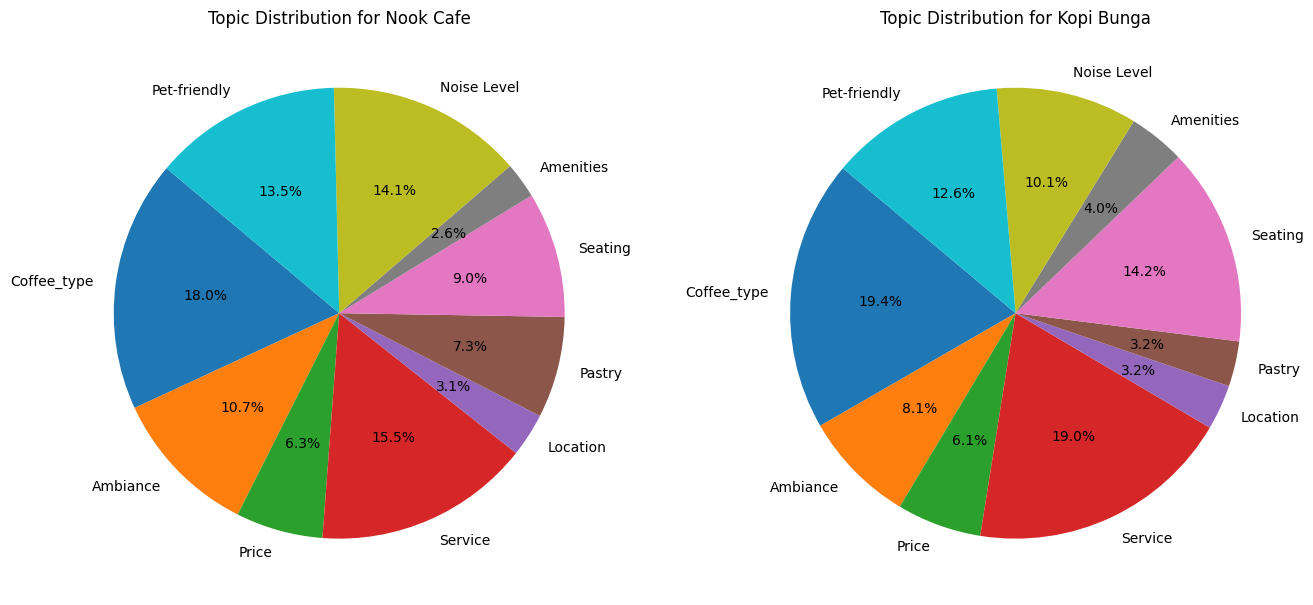

Nook Cafe excels in Coffee_type, while Kopi Bunga is best known for its Coffee_type.
However, Nook Cafe could improve on its Amenities, and Kopi Bunga has room for improvement in its Location.
If you prefer a coffee shop with excellent Coffee_type, Nook Cafe is a great choice.
Alternatively, if Coffee_type is more important to you, you might enjoy Kopi Bunga.

🤖: What would you like to do next?

            1. Start over to get another recommendation
            2. Comparison of two coffee shops
            3. Summarization of one coffee shop
            4. Exit
            
You: 3

🤖: Please enter the name of the coffee shop you want to summarize:
Coffee Shop Name: 103 Coffee


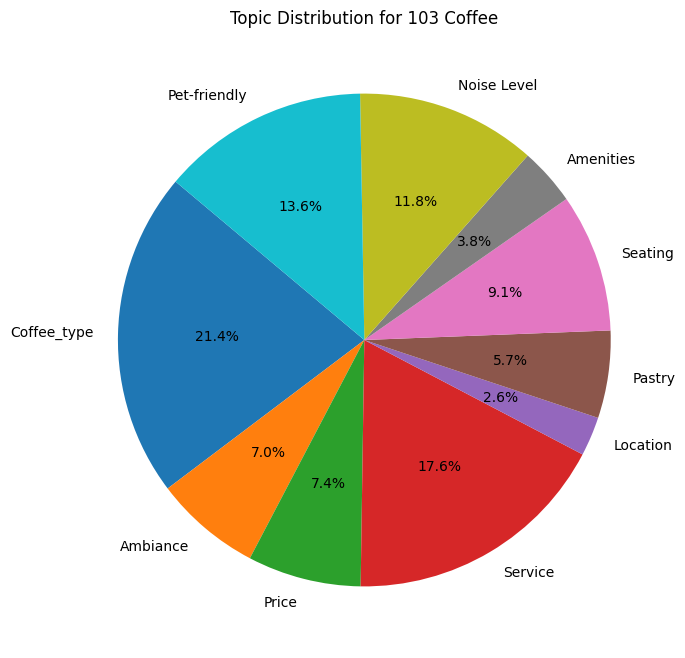

103 Coffee is known for its excellent Coffee_type.
However, it could improve on its Location.
Overall, if you are looking for a place with great Coffee_type, you should give it
a try.
I've been to many coffee shops in the city and I have never had any
problems finding one that was good enough or not so bad as this cafe! The
staff were friendly but they didn't seem too concerned about my order of tea (which
included some very nice teas) because there wasn'nt much else going on here at all...and
no matter how hard we tried our best to make sure everything went smoothly -
even though every time something came out wrong after just two minutes each way....it would
be better than nothing!!

🤖: What would you like to do next?

            1. Start over to get another recommendation
            2. Comparison of two coffee shops
            3. Summarization of one coffee shop
            4. Exit
            
You: 1
You: recommend me a coffee shop

🤖: Which state are you located in or prefer?
Yo

In [38]:
def main():
    start_conversation()
    state, topics, ranking_method, ranking_order = None, None, None, None

    while True:
        user_input = input("You: ")
        state, topics, ranking_method, ranking_order = extract_entities(user_input)

        if 'summarize' in user_input.lower() or 'compare' in user_input.lower():
            compare_or_summarize(user_input)
        else:
            if state and not recommender.state_exists(state):
                print(f"\n🤖: The state '{state}' is unavailable. Please provide a valid state.")
                state = None

            if not state and not topics:
                state = get_state()
                while not recommender.state_exists(state):
                    print(f"\n🤖: The state '{state}' is unavailable. Please provide a valid state.")
                    state = get_state()
                ranking_method = get_ranking_method()
                ranking_order = get_ranking_order()
                if ranking_method != '3':
                    topics = get_topics()
            elif state and not topics:
                ranking_method = get_ranking_method(state=state)
                ranking_order = get_ranking_order()
                if ranking_method != '3':
                    topics = get_topics()
            elif not state and topics:
                state = get_state()
                while not recommender.state_exists(state):
                    print(f"\n🤖: The state '{state}' is unavailable. Please provide a valid state.")
                    state = get_state()
                ranking_method = get_ranking_method(topics=topics)
                ranking_order = get_ranking_order()
            elif state and topics:
                ranking_method = get_ranking_method(state=state, topics=topics)
                ranking_order = get_ranking_order()

            display_recommendations(state, topics, ranking_method, ranking_order)

        while True:
            print("\n🤖: What would you like to do next?")
            print("""
            1. Start over to get another recommendation
            2. Comparison of two coffee shops
            3. Summarization of one coffee shop
            4. Exit
            """)

            next_action = input("You: ").strip()

            if next_action == '1':
                state, topics, ranking_method, ranking_order = None, None, None, None
                break  # Start over for a new recommendation
            elif next_action == '2':
                print("\n🤖: Please enter the names of the two coffee shops you want to compare:")
                coffee_shop1 = input("Coffee Shop 1: ").strip()
                coffee_shop2 = input("Coffee Shop 2: ").strip()
                compare_sentence = f"Can you compare {coffee_shop1} and {coffee_shop2}?"
                compare_or_summarize(compare_sentence)
            elif next_action == '3':
                print("\n🤖: Please enter the name of the coffee shop you want to summarize:")
                coffee_shop = input("Coffee Shop Name: ").strip()
                summarize_sentence = f"Can you summarize {coffee_shop}?"
                compare_or_summarize(summarize_sentence)
            elif next_action == '4':
                recommender.close()
                print("\n🤖: Goodbye! Enjoy your coffee!")
                return
            else:
                print("\n🤖: Invalid option. Please try again.")

if __name__ == "__main__":
    main()
